# Importing libraries

In [1]:
import os

from torch import nn
from torch.autograd import grad
import torch

from torch.utils.data import DataLoader
from torch import optim
from torch import autograd
from torch import nn
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import sampler
from argparse import ArgumentParser
#from wgan64x64 import *
from sklearn import metrics
from tqdm.auto import tqdm
import numpy as np
import time
import os
import sys
import random
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Enabling GPU capabilites

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]= "max_split_size_mb:21"
key = "PYTORCH_CUDA_ALLOC_CONF"
value = os.getenv(key)

print(value)

max_split_size_mb:21


In [3]:
options_c     = 0 # <- normal class
options_alpha = 1
options_cuda  = '0'
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
        torch.cuda.set_device('cuda:{}'.format(options_cuda))
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

# device2 = torch.device('cuda:{}'.format(options_cuda))
# torch.cuda.set_device('cuda:{}'.format(options_cuda))

cuda:0


# Loading the train, validation and test data sets

In [4]:
MODE = 'wgan-gp'  # Valid options are dcgan, wgan, or wgan-gp

LAMBDA = 10  # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 12  # How many critic iterations per generator iteration
BATCH_SIZE = 5  # Batch size

LATENT_SPACE_SIZE = 230

In [5]:
DIM = 160
OUTPUT_DIM = 3*160*160

TOP_CROP_POS = 50
LEFT_CROP_POS = 35

In [6]:
def one_class_dataloader(c, nw=0, bs=64):
    nw = 0
    # data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
    # test_dir = '../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
    data_dir = '../../Images/june5Night/Positive'      #This is for the home laptop
    test_dir = '../../Images/june5Night/Evaluation'      #This is for the home laptop

    val_dir = '../../Images/june5Night/Validation/'      #This is for the home laptop
    
    transform = transforms.Compose([
            # transforms.RandomCrop(32, padding=4),
            # transforms.RandomHorizontalFlip(),
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5),
            #                      (0.5, 0.5, 0.5)),
        ])

    dataset = datasets.ImageFolder(data_dir, transform = transform)
    trainloader = DataLoader(
        dataset, bs, num_workers=nw, pin_memory=True, drop_last=True) 
    
    dataset_test = datasets.ImageFolder(test_dir, transform = transform)
    dataloader_test = DataLoader(
        dataset_test, bs, num_workers=nw, pin_memory=True, drop_last=False) 
    
    dataset_val = datasets.ImageFolder(val_dir, transform = transform)
    dataloader_val = DataLoader(
        dataset_val, bs, num_workers=nw, pin_memory=True, drop_last=False) 


    # return trainloader, dataloader_test
    return trainloader, dataloader_test, dataloader_val

# Showing one sample of the training set images

In [7]:
dataloader, _, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)

In [8]:
images, labels = next(iter(dataloader))
images = images.to(device)
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0])
tensor(0.0157, device='cuda:0') tensor(1., device='cuda:0')


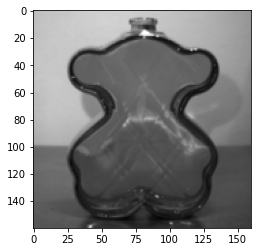

In [9]:
imgs_croped = transforms.functional.crop(images.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().cpu().numpy()

plt.imshow(single_img_numpy)

# Auxiliar model structures and functions

In [10]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st


class MyConvo2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True,  stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1)/2)
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size,
                              stride=1, padding=self.padding, bias=bias)

    def forward(self, input):
        output = self.conv(input)
        return output


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = self.conv(input)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = input
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, input_height, input_width, input_depth) = output.size()
        output_depth = int(input_depth / self.block_size_sq)
        output_width = int(input_width * self.block_size)
        output_height = int(input_height * self.block_size)
        t_1 = output.reshape(batch_size, input_height,
                             input_width, self.block_size_sq, output_depth)
        spl = t_1.split(self.block_size, 3)
        stacks = [t_t.reshape(batch_size, input_height,
                              output_width, output_depth) for t_t in spl]
        output = torch.stack(stacks, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, output_height, output_width, output_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class UpSampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, input):
        output = input
        output = torch.cat((output, output, output, output), 1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output


class ResidualBlock(nn.Module):
    # ResidualBlock(dim, dim*2, 3, 'down', 64)
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        if resample == 'down':
            self.bn1 = nn.LayerNorm([input_dim, hw, hw])
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        elif resample == 'up':
            self.bn1 = nn.BatchNorm2d(input_dim)
            self.bn2 = nn.BatchNorm2d(output_dim)
        elif resample == None:
            # TODO: ????
            self.bn1 = nn.BatchNorm2d(output_dim)
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        else:
            raise Exception('invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(
                input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                output_dim, output_dim, kernel_size=kernel_size)
        elif resample == None:
            self.conv_shortcut = MyConvo2d(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('invalid resample value')

    def forward(self, input):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = input
        else:
            shortcut = self.conv_shortcut(input)

        output = input
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output


class ReLULayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(ReLULayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.linear(input)
        output = self.relu(output)
        return output





# Building the generator and discriminator models

In [11]:
class FCGenerator(nn.Module):
    def __init__(self, FC_DIM=512):
        super(FCGenerator, self).__init__()
        self.relulayer1 = ReLULayer(128, FC_DIM)
        self.relulayer2 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer3 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer4 = ReLULayer(FC_DIM, FC_DIM)
        self.linear = nn.Linear(FC_DIM, OUTPUT_DIM)
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.relulayer1(input)
        output = self.relulayer2(output)
        output = self.relulayer3(output)
        output = self.relulayer4(output)
        output = self.linear(output)
        output = self.tanh(output)
        return output


class GoodGenerator(nn.Module):
    def __init__(self, dim=DIM, output_dim=OUTPUT_DIM):
        super(GoodGenerator, self).__init__()

        self.dim = dim

        # self.ln1 = nn.Linear(128, 4*4*8*self.dim)
        self.ln1 = nn.Linear(LATENT_SPACE_SIZE, 10*10*8*self.dim)
        self.rb1 = ResidualBlock(8*self.dim, 8*self.dim, 3, resample='up')
        self.rb2 = ResidualBlock(8*self.dim, 4*self.dim, 3, resample='up')
        self.rb3 = ResidualBlock(4*self.dim, 2*self.dim, 3, resample='up')
        self.rb4 = ResidualBlock(2*self.dim, 1*self.dim, 3, resample='up')
        self.bn = nn.BatchNorm2d(self.dim)

        self.conv1 = MyConvo2d(1*self.dim, 3, 3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # print("PEROFORMING FORWARD FUNCTION")
        # print("input shape is: ", input.shape)
        output = self.ln1(input.contiguous())
        # print("self.ln1 shape is: ", output.shape)
        # output = output.view(-1, 8*self.dim, 4, 4)
        output = output.view(-1, 8*self.dim, 10, 10)
        # print("output.view shape is: ", output.shape)
        output = self.rb1(output)
        # print("self.rb1 shape is: ", output.shape)
        output = self.rb2(output)
        # print("self.rb2 shape is: ", output.shape)
        output = self.rb3(output)
        # print("self.rb3 shape is: ", output.shape)
        output = self.rb4(output)
        # print("self.rb4 shape is: ", output.shape)

        output = self.bn(output)
        # print("self.bn shape is: ", output.shape)
        output = self.relu(output)
        # print("self.relu shape is: ", output.shape)
        output = self.conv1(output)
        # print("self.conv1 shape is: ", output.shape)
        output = self.tanh(output)
        # print("self.tanh shape is: ", output.shape)
        # print("END OF FORWARD FUNCTION")
        # # output = output.view(-1, OUTPUT_DIM)
        return output


class GoodDiscriminator(nn.Module):
    def __init__(self, dim=DIM):
        super(GoodDiscriminator, self).__init__()

        self.dim = dim

        self.conv1 = MyConvo2d(3, self.dim, 3, he_init=False)
        self.rb1 = ResidualBlock(self.dim, 2*self.dim,
                                 3, resample='down', hw=DIM)
        self.rb2 = ResidualBlock(
            2*self.dim, 4*self.dim, 3, resample='down', hw=int(DIM/2))
        self.rb3 = ResidualBlock(
            4*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/4))
        self.rb4 = ResidualBlock(
            8*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/8))
        # self.ln1 = nn.Linear(4*4*8*self.dim, 1)
        self.ln1 = nn.Linear(10*10*8*self.dim, 1)
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def extract_feature(self, input):
        # print("PEROFORMING EXTRACTING FEATURES FUNCTION")
        # print("input shape is: ", input.shape)
        output = input.contiguous()
        # print("input.contigous() shape is: ", output.shape)
        output = output.view(-1, 3, DIM, DIM)
        # print("new shape of output is: ", output.shape)
        output = self.conv1(output)
        # print("after self.conv1, the shape of output is: ", output.shape)
        output = self.rb1(output)
        # print("after self.rb1, the shape of output is: ", output.shape)
        output = self.rb2(output)
        # print("after self.rb2, the shape of output is: ", output.shape)
        output = self.rb3(output)
        # print("after self.rb3, the shape of output is: ", output.shape)
        output = self.rb4(output)
        # print("after self.rb4, the shape of output is: ", output.shape)
        # # output = output.view(-1, 4*4*8*self.dim)
        output = output.view(-1, 10*10*8*self.dim)
        # print("after output.view, the shape of output is: ", output.shape)
        # print("END OF THE EXTRACTING FEATURES FUNCTION")  
        return output

    def forward(self, input):
        output = self.extract_feature(input)
        # print("after self.extract_feature, the shape of output is: ", output.shape)
        output = self.ln1(output)
        # print("after self.ln1(output), the shape of output is: ", output.shape)
        output = output.view(-1)
        # print("after output.view(-1), the shape of output is: ", output.shape)
        # print("PEROFORMING FORWARD")
        return output

# Implementing F-AnoGan functions

In [12]:
sys.path.append(os.getcwd())        # Adding to the sys path, the current directory

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

In [13]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE)).contiguous()
    alpha = alpha.view(BATCH_SIZE, 3, DIM, DIM)
    alpha = alpha.to(device)

    fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    interpolates = alpha * real_data.cuda().detach() + ((1 - alpha) * fake_data.detach())           # For home laptop. GPU capabilites
    # interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())                # For work laptop. No GPU
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


def wgan_training(PreTrained=False,saveat=1000,genstart=0):
    netG = GoodGenerator().to(device)
    netD = GoodDiscriminator().to(device)
    if PreTrained: 
      print('loading pretrained discriminator-weights '+D_Model+'...')
      netD.load_state_dict(torch.load(D_Model))
      print('loading pretrained generator-weights '+G_Model+'...')
      netG.load_state_dict(torch.load(G_Model))

    #one = torch.FloatTensor([1]).to(device)
    one = torch.tensor(1, dtype=torch.float).to(device)
    mone = one * -1

    optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.0, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.0, 0.9))

    dataloader, _, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)
    D_real_list = []
    D_fake_list = []
    D_cost_list = []
    D_cost_mean_list = []                                           # Stores the average of the D_cost of the batches that were executed 
    G_cost_list = []
    
    for iteration in tqdm(range(1+genstart, WGAN_ITERS + 1)):
        #print('WGAN - Iteration:'+str(iteration))
        start_time = time.time()
        ############################
        # (1) Update D network
        ###########################
        for i, (_data, _) in enumerate(dataloader):
            if i == CRITIC_ITERS:
                break
            netD.zero_grad()

            # train with real

            real_data = _data.to(device)
            imgs_croped = transforms.functional.crop(real_data.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

            D_real = netD(imgs_croped.cuda())
            D_real = D_real.mean()
            D_real.backward(mone)
            D_real_list.append(D_real.item())

            # train with fake
            noise = torch.randn(BATCH_SIZE, LATENT_SPACE_SIZE)
            noise = noise.to(device)
            fake = netG(noise).detach()
            inputv = fake
            D_fake = netD(inputv)
            D_fake = D_fake.mean()
            D_fake.backward(one)
            D_fake_list.append(D_fake.item())

            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(netD, imgs_croped.cuda().data, fake.data)
            gradient_penalty.backward()

            # print "gradien_penalty: ", gradient_penalty

            D_cost = D_fake - D_real + gradient_penalty
            D_cost_list.append(D_cost.item())
            Wasserstein_D = D_real - D_fake
            optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()

        noise = torch.randn(BATCH_SIZE, LATENT_SPACE_SIZE)
        noise = noise.to(device)
        fake = netG(noise)
        G = netD(fake)
        G = G.mean()
        G.backward(mone)
        G_cost = -G
        optimizerG.step()
        G_cost_list.append(G_cost.item())
        D_cost_mean_list.append(np.mean(D_cost_list[-CRITIC_ITERS:])) 

        # Write logs and save samples

        if iteration % saveat == 0:
            save_image(fake*0.5+0.5, 'ForBottlesTrainingsV3/wgangp/fake_' + num2fixstr(iteration,5) + '.jpg')
            print('Iters:{}, D(real):{}, D(fake):{}, Loss D:{}, Loss G:{}'.format(
                iteration,
                np.mean(D_real_list),
                np.mean(D_fake_list),
                np.mean(D_cost_list),
                np.mean(G_cost_list),)
            )
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netD.state_dict(), 'ForBottlesTrainingsV3/models/netD_' + num2fixstr(iteration,5) + '.pth')
            torch.save(netG.state_dict(), 'ForBottlesTrainingsV3/models/netG_' + num2fixstr(iteration,5) + '.pth')
    # open file
    with open('ForBottlesTrainingsV3/G_cost_list.txt', 'w+') as g:
        # write elements of list
        for items in G_cost_list:
            g.write('%s\n' %items)
        print("G_cost_list written successfully")
    # close the file
    g.close() 

    # open file
    with open('ForBottlesTrainingsV3/D_cost_mean_list.txt', 'w+') as d:
        # write elements of list
        for items in D_cost_mean_list:
            d.write('%s\n' %items)
        print("D_cost_mean_list written successfully")
    # close the file
    d.close() 
    
    return D_cost_list
 

# Training WGAN

In [14]:
# !mkdir wgangp
# !mkdir rec
# !mkdir models

In [15]:
print(torch.cuda.is_available())

True


In [16]:
genstart   = 0 # generación de partida (en caso de existir entrenamiento previo)
G_Model    = 'ForBottlesTrainingsV3/models/netG_' + num2fixstr(genstart,5) + '.pth'
D_Model    = 'ForBottlesTrainingsV3/models/netD_' + num2fixstr(genstart,5) + '.pth'

saveat     = 100   # cada cuantas iteraciones se guarda modelo
WGAN_ITERS = 700  # iteraciones máximas del entrenamiento
# saveat     = 2   # cada cuantas iteraciones se guarda modelo
# WGAN_ITERS = 10  # iteraciones máximas del entrenamiento
pretrained = genstart>0

print(G_Model)
print(D_Model)

ForBottlesTrainingsV3/models/netG_00000.pth
ForBottlesTrainingsV3/models/netD_00000.pth


In [17]:
wgan_training(PreTrained=pretrained,saveat=saveat,genstart=genstart)

 10%|█         | 1/10 [01:01<09:16, 61.82s/it]

Iters:2, D(real):568.5391439000765, D(fake):-674.7997414469719, Loss D:-701.1873996655146, Loss G:767.4194030761719


 30%|███       | 3/10 [02:17<05:03, 43.31s/it]

Iters:4, D(real):781.3891703387102, D(fake):-452.73844629277784, Loss D:-698.4807339310646, Loss G:518.5670013427734


 50%|█████     | 5/10 [03:38<03:28, 41.75s/it]

Iters:6, D(real):842.236150112417, D(fake):-280.1097492625316, Loss D:-635.163236869706, Loss G:314.32749430338544


 70%|███████   | 7/10 [04:58<02:02, 40.84s/it]

Iters:8, D(real):886.5880076140165, D(fake):-142.56209397191802, Loss D:-585.3127610186735, Loss G:179.5445728302002


 90%|█████████ | 9/10 [06:20<00:40, 40.90s/it]

Iters:10, D(real):905.4683354735374, D(fake):-55.924072709679606, Loss D:-547.8359975417455, Loss G:96.84234619140625


100%|██████████| 10/10 [07:02<00:00, 42.24s/it]

G_cost_list written successfully
D_cost_mean_list written successfully


[2.183079719543457,
 -119.0796890258789,
 -276.6693420410156,
 -525.9177856445312,
 -571.3550415039062,
 -523.7120361328125,
 -780.5554809570312,
 -391.65673828125,
 -546.9683837890625,
 -628.6747436523438,
 -711.9774169921875,
 -782.6060180664062,
 -888.9293823242188,
 -906.0316162109375,
 -1205.748046875,
 -1044.053955078125,
 -758.06591796875,
 -900.9684448242188,
 -1267.273681640625,
 -278.91015625,
 -830.623291015625,
 -915.4114379882812,
 -1061.603515625,
 -913.8885498046875,
 -651.8929443359375,
 -679.0731201171875,
 -776.6837158203125,
 -836.9686279296875,
 -872.81005859375,
 -961.7135620117188,
 -1067.114013671875,
 -209.0936279296875,
 -691.27392578125,
 -815.7703857421875,
 -947.3462524414062,
 -794.0116577148438,
 -681.1439819335938,
 -659.0936889648438,
 -462.03961181640625,
 -650.3883666992188,
 -634.5912475585938,
 -671.2464599609375,
 -564.0740966796875,
 -579.4617919921875,
 -615.71923828125,
 -642.220947265625,
 -573.1263427734375,
 -661.719970703125,
 -559.0565185546

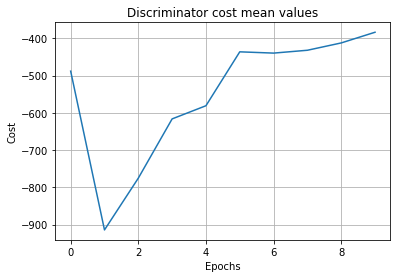

In [19]:
# Load data from the text file
with open("ForBottlesTrainingsV3/D_cost_mean_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Discriminator cost mean values")
plt.grid(True)
plt.show()

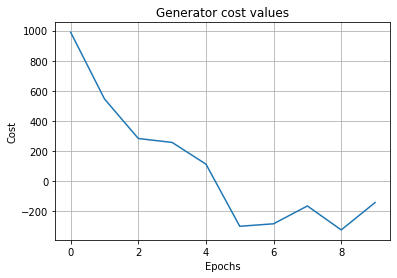

In [20]:
# Load data from the text file
with open("ForBottlesTrainingsV3/G_cost_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Generator cost values")
plt.grid(True)
plt.show()